In [1]:
import os
import gc

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import seaborn as sns
from scipy import stats
import re
import numpy.ma as ma

from hbmep.config import Config
from hbmep.nn import functional as F
from hbmep.model.utils import Site as site

from models import NonHierarchicalBayesianModel
from constants import (
    DATA_PATH,
    TOML_PATH
)

import math


In [2]:
USER = os.environ["USER"]
 
 
src = f"/home/{USER}/repos/rat-mapping-paper/reports/C_SMA_LAR/processed_inference_efficacy.pkl"
with open(src, "rb") as f:
    (
        df,
        encoder_dict,
        model,
        posterior_samples,
        a,
        subjects,
        contacts,
        positions,
        left_degrees,
        size,
    ) = pickle.load(f)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


# Heatmap

In [3]:
df.columns

Index(['pulse_amplitude', 'pulse_train_frequency', 'pulse_period',
       'pulse_duration', 'pulse_count', 'train_delay', 'channel1_1',
       'channel1_2', 'channel1_3', 'channel1_4', 'channel2_1', 'channel2_2',
       'channel2_3', 'channel2_4', 'charge_params_1', 'charge_params_2',
       'charge_params_3', 'charge_params_4', 'bank_check', 'run', 'enabled',
       'channel_failA', 'channel_failB', 'channel_fail_comb', 'time_pulse',
       'time', 'ix_onsets', 'LBiceps', 'LFCR', 'LECR', 'LTriceps', 'LADM',
       'LDeltoid', 'LBicepsFemoris', 'RBiceps', 'channel1_laterality',
       'channel1_segment', 'channel1_designation', 'channel1_size',
       'channel2_laterality', 'channel2_segment', 'channel2_designation',
       'channel2_size', 'compound_position', 'compound_charge_params',
       'compound_size', 'participant', 'subdir_pattern', 'charge_param_error'],
      dtype='object')

In [4]:
df['channel2_designation'].unique()

array(['LL', 'LM', 'M', 'L', 'RR', 'LM2', 'RM', 'R', 'LM1'], dtype=object)

In [5]:
df['participant']

0        0
1        0
2        0
3        0
4        0
        ..
20803    7
20804    7
20805    7
20806    7
20807    7
Name: participant, Length: 20808, dtype: int64

In [6]:
df[df['participant']==1]['channel2_designation'].unique()

array(['LL', 'L', 'M', 'LM', 'RR', 'R', 'LM1', 'RM', 'LM2'], dtype=object)

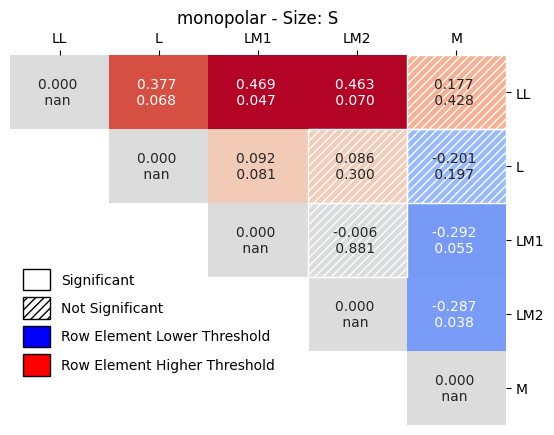

In [5]:
contact_ind = 0 # mono or bi
size_ind = 1 # big or small

### NEEDS TO BE CHANGED WHEN CHANGING SIZE/CONTACT
### ['LL', 'L', 'LM', 'LM1', 'LM2', 'M']
ind = [0, 1, 3,4,5]


### ACTUAL CALCULATION
a_test = a[:,contact_ind,:,:,size_ind,...]
a_test = a_test / ma.median(a_test, axis = (1,2,-1), keepdims=True)

a_mean = ma.mean(a_test, axis=(1,-2, -1))
a_mean.shape

t = (a_mean[:, :, None] - a_mean[:, None, :])
test = stats.ttest_1samp(t, popmean=0, alternative="two-sided", axis=(0))

### GET MEAN TO PLOT
p_mean = t.mean(axis=0)
### GET P VALUES
p = test.pvalue
### MASK NANs
p_mean = p_mean[~p_mean.mask]
p_mean = p_mean.reshape(len(ind),len(ind))

### GET VALUES WE WANT TO PLOT
p_ = p[ind, :][:, ind]

#FOR ANNOTATION
data = []
for ind_i, i in enumerate(p_):
    for ind_j, j in enumerate(i):
        data.append(f"{p_mean[ind_i, ind_j]:.3f} \n {j:.3f}  ")
        
data = np.array(data).reshape(len(ind),len(ind))

#MASK LOWER TRIANGLE
mask2= np.array(p_)
mask2 = np.tril(np.ones_like(mask2), k=-1).astype(bool)

#CORRECT LABELS
labels = np.array(left_degrees)
labels = labels.astype('U20')

if contact_ind == 0:
    labels[ind] = labels[ind]
else:
    labels[ind] = np.char.add(labels[ind],"-M")

if size_ind == 0:
    a_mean_big = a_mean
else:
    a_mean_small = a_mean

# #PLOT
ax=sns.heatmap(p_mean, xticklabels=labels[ind], yticklabels=labels[ind],annot=data,fmt = '',center = 0, cmap = "coolwarm",cbar = False, mask = mask2)


##ADD HATCH FOR SIGNIFICANCE
handles = []
hatch_mask = p_ > 0.1

for i in range (p_.shape[0]):
    for j in range(p_.shape[1]):
        if hatch_mask[i, j]:
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, hatch='////', edgecolor='white'))
handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                    hatch='', label="Significant"))
handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                    hatch='////', label="Not Significant"))
handles.append(plt.Rectangle((0, 0), 0, 0, color='blue', ec='black',
                    hatch='', label="Row Element Lower Threshold"))
handles.append(plt.Rectangle((0, 0), 0, 0, color='Red', ec='black',
                    hatch='', label="Row Element Higher Threshold"))
ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(0, .1),
        handlelength=2, handleheight=2, frameon=False)
ax.tick_params(left= False,labelleft = False, bottom= False,labelbottom= False,right=True, top=True, labelright=True, labeltop=True, labelrotation=0)

ax.yaxis.tick_right()
ax.title.set_text(f"{contacts[contact_ind]}polar - Size: {size[size_ind]}")

In [6]:
def musc_ind(musc, contact, size_i, plot):
    contact_ind = contact # mono or bi
    size_ind = size_i # big or small
    musc_ind = musc

    ### NEEDS TO BE CHANGED WHEN CHANGING SIZE/CONTACT
    ### ['LL', 'L', 'LM', 'LM1', 'LM2', 'M']
    if size_ind == 0:
        ind = [0, 1, 2,5]
    else: 
        ind = [0, 1, 3,4,5]


    ### ACTUAL CALCULATION
    a_test = a[:,contact_ind,:,:,size_ind,:,musc_ind]
    a_test = a_test / ma.median(a_test, axis = (1,2), keepdims=True)

    a_mean = ma.mean(a_test, axis=(1, -1))
    a_mean.shape

    t = (a_mean[:, :, None] - a_mean[:, None, :])
    test = stats.ttest_1samp(t, popmean=0, alternative="two-sided", axis=(0))

    ### GET MEAN TO PLOT
    p_mean = t.mean(axis=0)
    ### GET P VALUES
    p = test.pvalue
    ### MASK NANs
    p_mean = p_mean[~p_mean.mask]
    p_mean = p_mean.reshape(len(ind),len(ind))

    ### GET VALUES WE WANT TO PLOT
    p_ = p[ind, :][:, ind]

    #FOR ANNOTATION
    data = []
    for ind_i, i in enumerate(p_):
        for ind_j, j in enumerate(i):
            data.append(f"{p_mean[ind_i, ind_j]:.3f} \n {j:.3f}  ")
            
    data = np.array(data).reshape(len(ind),len(ind))

    #MASK LOWER TRIANGLE
    mask2= np.array(p_)
    mask2 = np.tril(np.ones_like(mask2), k=-1).astype(bool)

    #CORRECT LABELS
    labels = np.array(left_degrees)
    labels = labels.astype('U20')

    if contact_ind == 0:
        labels[ind] = labels[ind]
    else:
        labels[ind] = np.char.add(labels[ind],"-M")

    if plot == 1: 
        #PLOT
        
        ax=sns.heatmap(p_mean, xticklabels=labels[ind], yticklabels=labels[ind],annot=data,fmt = '',center = 0, cmap = "coolwarm",cbar = False, mask = mask2)


        ##ADD HATCH FOR SIGNIFICANCE
        handles = []
        hatch_mask = p_ > 0.1

        for i in range (p_.shape[0]):
            for j in range(p_.shape[1]):
                if hatch_mask[i, j]:
                    ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, hatch='////', edgecolor='white'))
        handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                            hatch='', label="Significant"))
        handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                            hatch='////', label="Not Significant"))
        handles.append(plt.Rectangle((0, 0), 0, 0, color='blue', ec='black',
                            hatch='', label="Row Element Lower Threshold"))
        handles.append(plt.Rectangle((0, 0), 0, 0, color='Red', ec='black',
                            hatch='', label="Row Element Higher Threshold"))
        ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(0, .1),
                handlelength=2, handleheight=2, frameon=False)
        ax.tick_params(left= False,labelleft = False, bottom= False,labelbottom= False,right=True, top=True, labelright=True, labeltop=True, labelrotation=0)

        ax.yaxis.tick_right()
        ax.title.set_text(f"{contacts[contact_ind]}polar - Size: {size[size_ind]} - Muscle: {model.response[musc]}")
        
    return a_mean

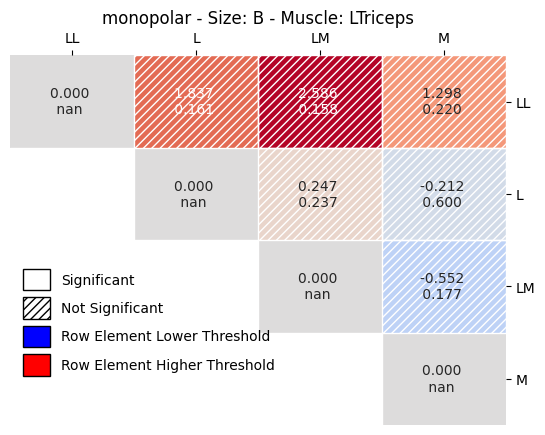

In [8]:
a_big = musc_ind(5, 0, 0, 1)

In [9]:
def round_significant_digits(x, dtype=np.float64, precision=4):
    string = np.format_float_positional(x, unique=False, fractional=False, trim='k', precision=precision)
    return dtype(string)
    

In [11]:
left_degrees

['LL', 'L', 'LM', 'LM1', 'LM2', 'M']

In [7]:
def rank(musc_ind, size_ind):
    arr = []
    total_count = []
    direc_count = []
    
    if size_ind == 0:
        ind = [0, 1, 2,5]
        labels = [left_degrees[l] for l in (0,1,2,5)]
    else:
        ind = [0, 1, 3,4,5]
        labels = [left_degrees[l] for l in (0,1,3,4,5)]
    
    for l_ind, l in enumerate(left_degrees):
        for l2_ind, l2 in enumerate(left_degrees):
            counter = 0
            total_counter =0
            direc = 0
            for s_ind,s in enumerate(subjects):
                temp_one = a[s_ind,0,:,l_ind,size_ind,:,musc_ind]
                temp_two = a[s_ind,0,:,l2_ind,size_ind,:,musc_ind]
                if temp_one.mask.all() and temp_two.mask.all():
                    pass
                else:
                    total_counter+=1
                temp_one = ma.mean(temp_one, axis = (0))
                temp_two = ma.mean(temp_two, axis = (0))
                if ma.mean(temp_one < temp_two) >0.95:
                    counter += 1
                if ma.mean(temp_one - temp_two) < 0:
                    direc += 1
                # else:
                    # print("Not Significant")
                    
            arr.append(counter)
            total_count.append(total_counter)
            direc_count.append(direc)

    arr = np.array(arr)
    arr = arr.reshape(len(left_degrees), len(left_degrees))
    total_count = np.array(total_count)
    total_count = total_count.reshape(len(left_degrees), len(left_degrees))
    direc_count = np.array(direc_count)
    direc_count = direc_count.reshape(len(left_degrees), len(left_degrees))
    
    ratio = arr / total_count

    round_significant_digits_vectorized = np.vectorize(round_significant_digits, )
    ratio = round_significant_digits_vectorized(ratio, precision=3)
    
    ratio = ratio[np.ix_(ind,ind)]
    arr_graph = arr[np.ix_(ind,ind)]
    
    ax = sns.heatmap(ratio,xticklabels=labels, yticklabels=labels,annot = ratio, fmt = '',center = 0, cmap = "coolwarm",cbar = False)
    ax.tick_params(left= False,labelleft = False, bottom= False,labelbottom= False,right=True, top=True, labelright=True, labeltop=True, labelrotation=0)
    ax.yaxis.tick_right()

    ax.set_title(f"{model.response[musc_ind]}")
    
              

In [8]:
def bvs_rank(musc_ind, graph_this):
    arr = []
    total_count = []
    direc_count = []
    
    if size_ind == 0:
        ind = [0, 1, 2,5]
        labels = [left_degrees[l] for l in (0,1,2,5)]
    else:
        ind = [0, 1, 3,4,5]
        labels = [left_degrees[l] for l in (0,1,3,4,5)]
    
    for l_ind, l in enumerate(left_degrees):
        for l2_ind, l2 in enumerate(left_degrees):
            counter = 0
            total_counter =0
            direc = 0
            for s_ind,s in enumerate(subjects):
                temp_one = a[s_ind,0,:,l_ind,0,:,musc_ind]
                temp_two = a[s_ind,0,:,l2_ind,1,:,musc_ind]
                if temp_one.mask.all() or temp_two.mask.all():
                    pass
                else:
                    total_counter+=1
                temp_one = ma.mean(temp_one, axis = (0))
                temp_two = ma.mean(temp_two, axis = (0))
                if ma.mean(temp_one < temp_two) > 0.95:
                    counter += 1
                if ma.mean(temp_one - temp_two) < 0:
                    direc += 1
                # else:
                    # print("Not Significant")
                    
            arr.append(counter)
            total_count.append(total_counter)
            direc_count.append(direc)

    
    arr = np.array(arr)
    arr = arr.reshape(len(left_degrees), len(left_degrees))
    total_count = np.array(total_count)
    total_count = total_count.reshape(len(left_degrees), len(left_degrees))
    direc_count = np.array(direc_count)
    direc_count = direc_count.reshape(len(left_degrees), len(left_degrees))
    
    ratio = arr / total_count

    round_significant_digits_vectorized = np.vectorize(round_significant_digits, )
    ratio = round_significant_digits_vectorized(ratio, precision=3)

    indcol = (0,1,3,4,5)
    indrow = (0,1,2,5)


    ratio_graph = ratio[np.ix_(indrow,indcol)]
    arr_graph = arr[np.ix_(indrow,indcol)]
    total_graph = total_count[np.ix_(indrow,indcol)]
    
    if graph_this == "ratio":
        text_graph = ratio_graph
    elif graph_this == "arr":
        text_graph = arr_graph
    else:
        text_graph = total_graph

    xtick = [f"Small {left_degrees[l]}" for l in (0,1,3,4,5)]
    ytick = [f"Big {left_degrees[l]}" for l in (0,1,2,5)]
    
    ax = sns.heatmap(text_graph,xticklabels=xtick, yticklabels=ytick,annot = text_graph, fmt = '',center = 0, cmap = "coolwarm",cbar = False)
    ax.tick_params(left= False,labelleft = False, bottom= False,labelbottom= False,right=True, top=True, labelright=True, labeltop=True, labelrotation=0)
    ax.yaxis.tick_right()
    ax.set_title(f"{model.response[musc_ind]}, Row More Efficient")
    ax = plt.gca()  # Get current axis
    for i in range(len(ytick)):
        for j in range(len(xtick)):
            if ytick[i].split(' ')[-1] == xtick[j].split(' ')[-1]:  # Condition where suffix matches
                rect = Rectangle((j, i), 1, 1, fill=False, edgecolor='black', lw=2)
                ax.add_patch(rect)
            if ytick[i].split(' ')[-1] == "LM" and (xtick[j].split(' ')[-1] == "LM1" or xtick[j].split(' ')[-1] == "LM2"):
                rect = Rectangle((j, i), 1, 1, fill=False, edgecolor='black', lw=2)
                ax.add_patch(rect)
    

In [9]:
bvs_rank(0, "ratio")

/tmp/ipykernel_259178/1627424791.py:46: RuntimeWarning: invalid value encountered in divide
  ratio = arr / total_count


NameError: name 'round_significant_digits' is not defined

In [10]:
musc_ind = 5
size_ind = 1

rank(musc_ind, size_ind)

/tmp/ipykernel_259178/1938244999.py:45: RuntimeWarning: invalid value encountered in divide
  ratio = arr / total_count


NameError: name 'round_significant_digits' is not defined

# Comparing Big vs Small

In [11]:
### ACTUAL CALCULATION
a_big = a[:,contact_ind,:,:,0,...]
a_small = a[:,contact_ind,:,:,1,...]

a_big = a_big / ma.median(a_big, axis = (1,2,-1), keepdims=True)
a_small = a_small / ma.median(a_small, axis = (1,2,-1), keepdims=True)

a_big_mean = ma.mean(a_big, axis=(1,-2, -1))
a_small_mean = ma.mean(a_small, axis=(1,-2, -1))

t = (a_big_mean[:,:] - a_small_mean[:,:])
test = stats.ttest_1samp(t, popmean=0, alternative="two-sided", axis=(0))

### GET MEAN TO PLOT
p_mean = t.mean(axis=0)
### GET P VALUES
p = test.pvalue

In [12]:
contact_ind = 1

In [13]:
a_big = a[:,contact_ind,:,:,0,...]
a_small = a[:,contact_ind,:,:,1,...]
a_small.shape

(8, 3, 6, 4000, 6)

In [14]:
left_degrees

['LL', 'L', 'LM', 'LM1', 'LM2', 'M']

In [15]:
a_small = a_small[..., [0, 1, 3, 4, -1], :, :]
a_big = a_big[..., [0, 1, 2, 2, -1], :, :]
assert a_big.shape == a_small.shape


In [16]:
a_big = a_big / ma.median(a_big, axis = (1,2,-1), keepdims=True)
a_small = a_small / ma.median(a_small, axis = (1,2,-1), keepdims=True)


In [17]:
a_big_mean = ma.mean(a_big, axis=(-2))
a_small_mean = ma.mean(a_small, axis=(-2))
a_small_mean.shape


(8, 3, 5, 6)

In [18]:
a_big_mean = ma.mean(a_big, axis=(1,-2, -1))
a_small_mean = ma.mean(a_small, axis=(1,-2, -1))
a_small_mean.shape

(8, 5)

In [19]:
t = (a_big_mean - a_small_mean)
t.shape
test = stats.ttest_1samp(t, popmean=0, alternative="two-sided", axis=(0, 1, -1))


AxisError: `axis` must contain only distinct elements

In [23]:
p = test.pvalue
p

array([0.27341971, 0.63826043,        nan,        nan,        nan,
       0.54811375])

In [24]:
left_degrees

['LL', 'L', 'LM', 'LM1', 'LM2', 'M']

In [25]:
test.confidence_interval()

ConfidenceInterval(low=array([-0.24445659, -0.51058809,         nan,         nan,         nan,
       -0.29708155]), high=array([0.7191628 , 0.35267488,        nan,        nan,        nan,
       0.17193484]))

In [26]:
### GET MEAN TO PLOT
p_mean = t.mean(axis=0)
### GET P VALUES



# Electrode config graphing

In [20]:
src = "/home/andres/repos/rat-mapping-paper/notebooks/C_SMA_LAR/selectivity_means.pkl"
with open(src, "rb") as f:
    selectivity_small, selectivity_big = pickle.load(f)

In [45]:
selectivity_small.shape

(8, 6)

Text(0.5, 1.0, 'Thresholds for monopolar')

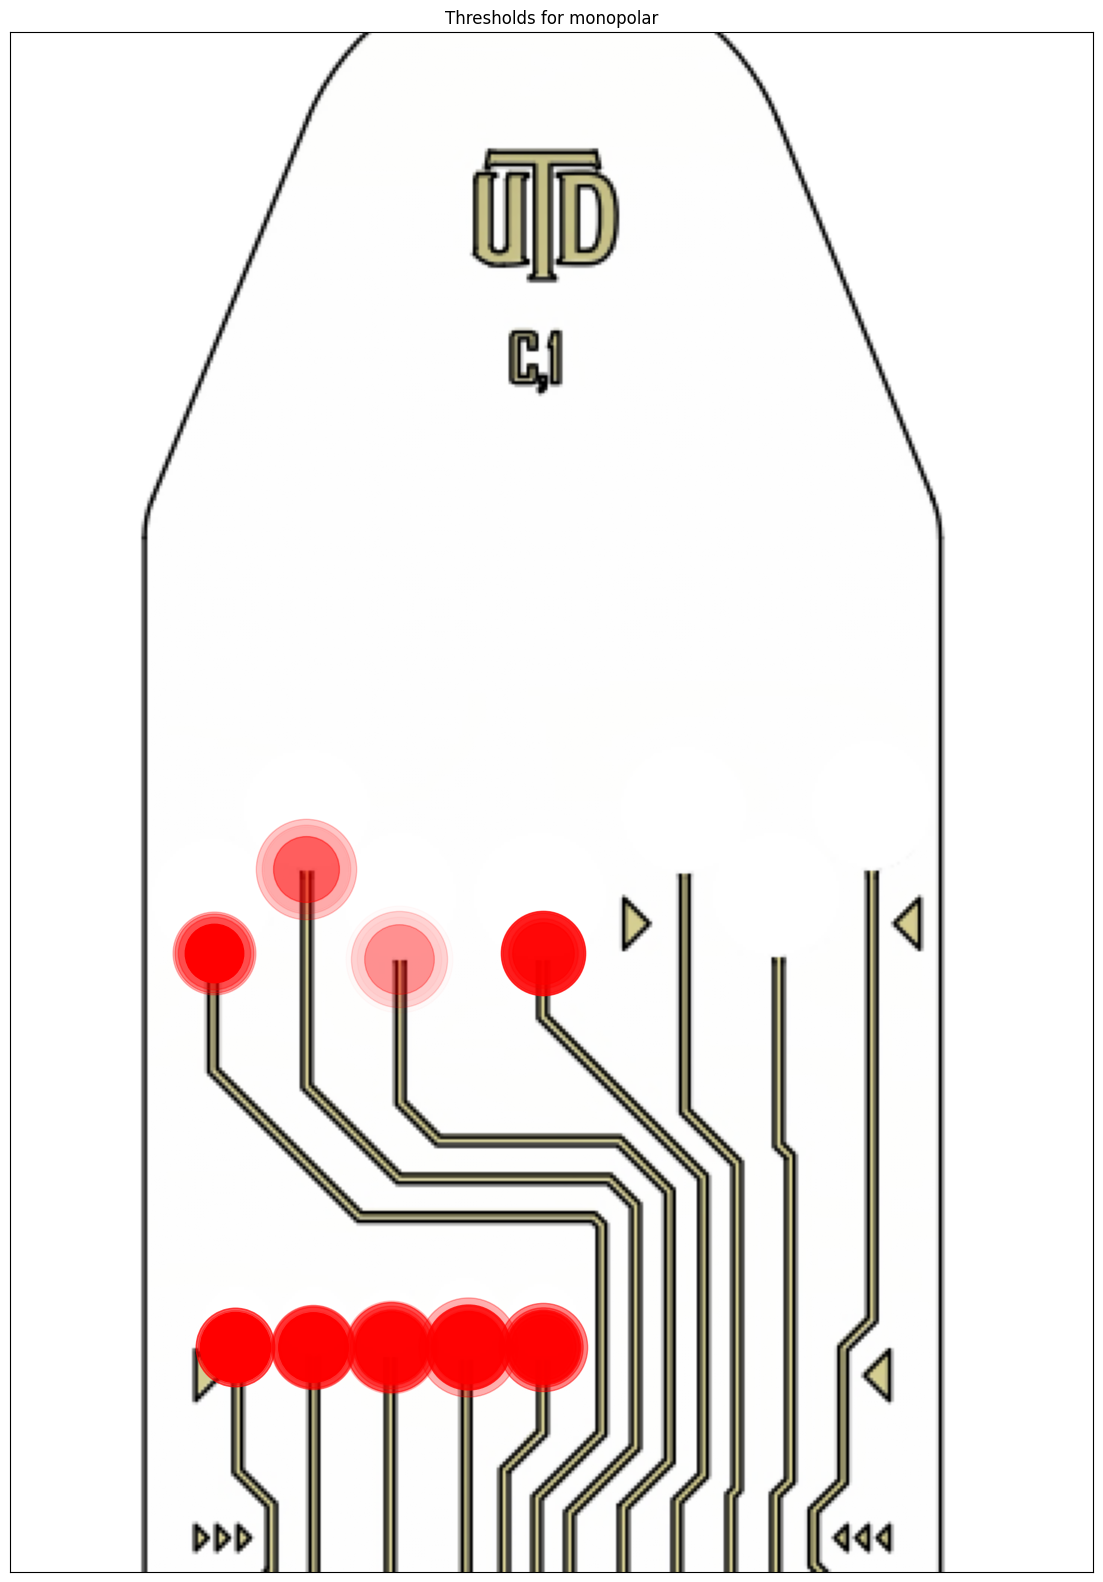

In [28]:
contact_ind = 0 # mono or bi
size_ind = 1 # big or small

### NEEDS TO BE CHANGED WHEN CHANGING SIZE/CONTACT
### ['LL', 'L', 'LM', 'LM1', 'LM2', 'M']

### ACTUAL CALCULATION
a_big = a[:,contact_ind,:,:,0,...]
a_big = a_big / ma.median(a[:,contact_ind,:,:,0,...], axis = (1,2,3,-1), keepdims=True)

a_small = a[:,contact_ind,:,:,1,...]
a_small = a_small / ma.median(a[:,contact_ind,:,:,1,...], axis = (1,2,3,-1), keepdims=True)

a_mean_big = ma.mean(a_big, axis=(1,-2, -1))
a_mean_small = ma.mean(a_small, axis=(1,-2, -1))


x_vals_big = {"LL":(67.7, 308), "L":(98.7, 280), "LM":(130, 310), "M": (178, 308)}
x_vals_small = {"LL":(75, 440), "L":(101, 440), "LM1":(127, 440), "LM2": (153, 440), "M": (178, 440)}
    
pvalues = []
mask = []
data = []
mean_list_big = []
mean_list_small = []

for sub_ind, s in enumerate(subjects):
    for l_ind, l in enumerate(left_degrees):
        if a_mean_big.mask[sub_ind,l_ind].all():
                continue
            
        mean_list_big.append(
            (
                subjects[sub_ind],
                left_degrees[l_ind],
                a_mean_big[sub_ind,l_ind],
                (selectivity_big[sub_ind, l_ind])
            )
        )
        
for sub_ind, s in enumerate(subjects):
    for l_ind, l in enumerate(left_degrees):
        if a_mean_small.mask[sub_ind,l_ind].all():
                continue
            
        mean_list_small.append(
            (
                subjects[sub_ind],
                left_degrees[l_ind],
                a_mean_small[sub_ind,l_ind],
                selectivity_small[sub_ind, l_ind]
            )
        )
        


im = plt.imread("/home/andres/C_SMA_LAR_white2.png")

plt.figure(figsize=(20, 20))

max_big = max([x[3] for x in mean_list_big])
max_small = max([x[3] for x in mean_list_small])

mean_big_alphas = [x[3]/max_big for x in mean_list_big]
mean_small_alphas = [x[3]/ max_small for x in mean_list_small]

mean_big_alphas = [x**2 for x in mean_big_alphas]
mean_small_alphas =  [x**2 for x in mean_small_alphas]

for i, z in enumerate(mean_list_big):
    if z[1] not in x_vals_big:
        continue
    eff_size = 1 / mean_list_big[i][2]*3500
    plt.scatter(x_vals_big[z[1]][0], x_vals_big[z[1]][1], s = eff_size,alpha=mean_big_alphas[i], color="red")

for i, z in enumerate(mean_list_small):
    if z[1] not in x_vals_small:
        continue
    eff_size = 1 / mean_list_small[i][2]*3500
    plt.scatter(x_vals_small[z[1]][0], x_vals_small[z[1]][1], s = eff_size,alpha=mean_small_alphas[i], color="red")

implot = plt.imshow(im)
plt.xticks([])
plt.yticks([])
plt.title(f"Thresholds for {contacts[contact_ind]}polar")


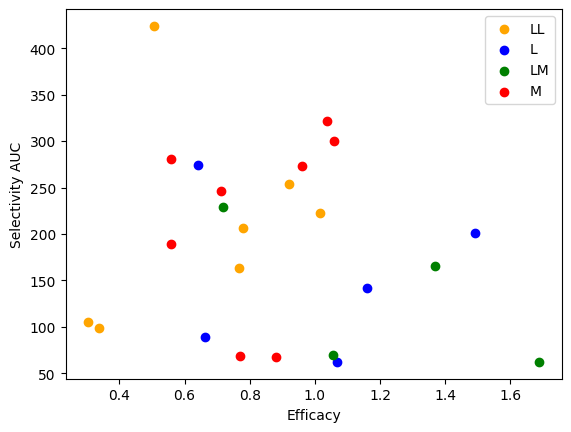

In [29]:

is_not_labeled = {}
for i,z in enumerate(mean_list_big):
    if z[1] in is_not_labeled:
        is_not_labeled[z[1]] = False
    else:
        is_not_labeled[z[1]] = True
    plt.scatter(1/z[2], z[3], color=color_dict[z[1]], label=z[1] if is_not_labeled[z[1]] else None)
    # sns.scatterplot(x=np.array([1/z[2]]), y=np.array([z[3]]), color=color_dict[z[1]])


plt.xlabel("Efficacy")
plt.ylabel("Selectivity AUC")
# plt.legend(color_dict.keys())
# plt.legend(color_dict.values(), color_dict.keys())
plt.legend()


In [102]:
a.shape

(8, 2, 3, 6, 2, 4000, 6)

In [ ]:
# sub, contact(mono, bi), segment, left_degrees, size, ps, muscle

In [106]:
contacts

['mono', 'bi']

In [108]:
curr_a.shape

(8, 3, 6, 4000, 6)

(8, 6, 6)

In [124]:
left_degrees

['LL', 'L', 'LM', 'LM1', 'LM2', 'M']

In [126]:
paired_diff_sel.shape

(8, 6, 6)

In [131]:
left_degrees

['LL', 'L', 'LM', 'LM1', 'LM2', 'M']

In [136]:
selectivity_big[0, left] - selectivity_big[0, right]

36.91313541932713

# Efficacy

In [109]:
src = "/home/andres/repos/rat-mapping-paper/notebooks/C_SMA_LAR/selectivity_means.pkl"
with open(src, "rb") as f:
    selectivity_small, selectivity_big = pickle.load(f)

In [110]:
selectivity_small

masked_array(
  data=[[101.37466219504248, 54.025131075187616, --, 44.02100523194992,
         38.747512919368845, 34.56428468408883],
        [200.55062219763855, 266.02800247720575, --, 359.8124517000672,
         303.7850539958004, 378.6089077486879],
        [192.66460834416657, 149.32897495547306, --, 146.6376560364044,
         167.73782703016843, 172.41977350322068],
        [494.47932024712367, 482.80039574275145, --, 429.74805009179096,
         426.1893508623026, 417.3981001062003],
        [235.39705021106988, 237.6444887140148, --, 290.49887645512285,
         324.66908716230796, 345.10696158645607],
        [328.52621424750896, 329.2186170608936, --, 388.4297209785519,
         419.86124024803996, 377.78124637750255],
        [273.4315689713185, 269.88014856380295, --, 216.3085523469936,
         275.7423273279471, 344.3003402234975],
        [158.3550056759155, 129.01675991887484, --, 91.7071413005744,
         101.6356280758531, 89.57459870326659]],
  mask=[[False, False

In [112]:
curr_a = a[:,0,:,:,0,...]
curr_a.shape
curr_a = curr_a / ma.median(curr_a, axis = (1,2,3,-1), keepdims=True)


paired_diff_eff = curr_a[:, :,:,None,...] - curr_a[:,:,None,...]

paired_diff_eff = ma.mean(paired_diff_eff, axis=(1, -1,-2))

paired_diff_sel = selectivity_big[:,:,None] - selectivity_big[:,None,:]

(8, 3, 6, 6, 4000, 6)

In [29]:
selectivity_big = selectivity_big / ma.median(selectivity_big, axis = (-1), keepdims=True)

In [32]:
paired_diff_sel = selectivity_big[:,:,None] - selectivity_big[:,None,:]

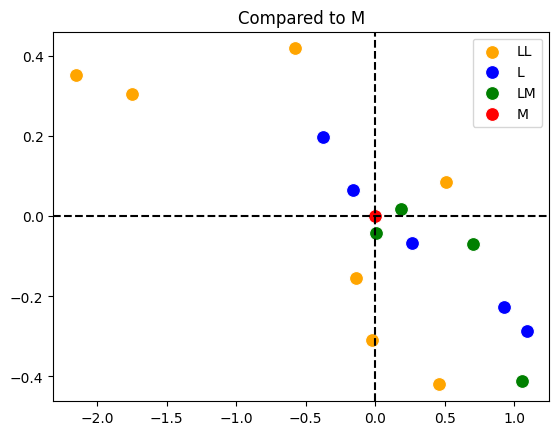

In [11]:
color_dict = {"L": "blue", "LM": "green", "M": "red", "LL": "orange", "LM1": "purple", "LM2": "black" }
plt.axvline(0, linestyle="dashed", color = "black")
plt.axhline(0, linestyle="dashed", color = "black")
plt.title(f"Compared to M")

for right in range(len(left_degrees)):
    x = paired_diff_eff[:,5, right]
    y = -paired_diff_sel[:,5, right]
    sns.scatterplot(x=x, y=y, color = color_dict[left_degrees[right]], label=left_degrees[right], s=100)

plt.legend();


In [33]:
comp_M_eff = paired_diff_eff[:,5,:]
comp_M_sel = paired_diff_sel[:,5,:]

avg_eff = ma.mean(comp_M_eff, axis = (0))
avg_sel = ma.mean(comp_M_sel, axis = (0))

sem_eff = []
sem_sel = []
for i in range(6):
    sem_eff.append(ma.std(comp_M_eff[:,i]) / ma.sqrt(ma.count(comp_M_eff[:,i])))
    sem_sel.append(ma.std(comp_M_sel[:,i]) / ma.sqrt(ma.count(comp_M_eff[:,i])))

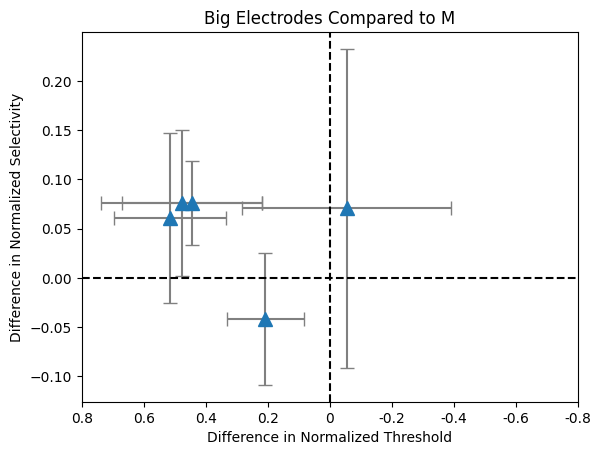

In [116]:
plot_ind = [0, 1, 2, 3, 4]
plt.errorbar(x=avg_eff[plot_ind], y=-avg_sel[plot_ind], yerr=sem_sel[:5], xerr=sem_eff[:5], fmt='^', capsize=5,ms = 10, ecolor='gray', label='Avg with SEM')
plt.xlabel("Difference in Normalized Threshold")
plt.ylabel("Difference in Normalized Selectivity")
plt.title(f"Big Electrodes Compared to M")
plt.axvline(0, linestyle="dashed", color = "black")
plt.axhline(0, linestyle="dashed", color = "black")
xticks=[0.8, 0.6, 0.4, 0.2, 0, -0.2, -0.4, -0.6, -0.8]
plt.xticks(xticks, reversed(xticks));


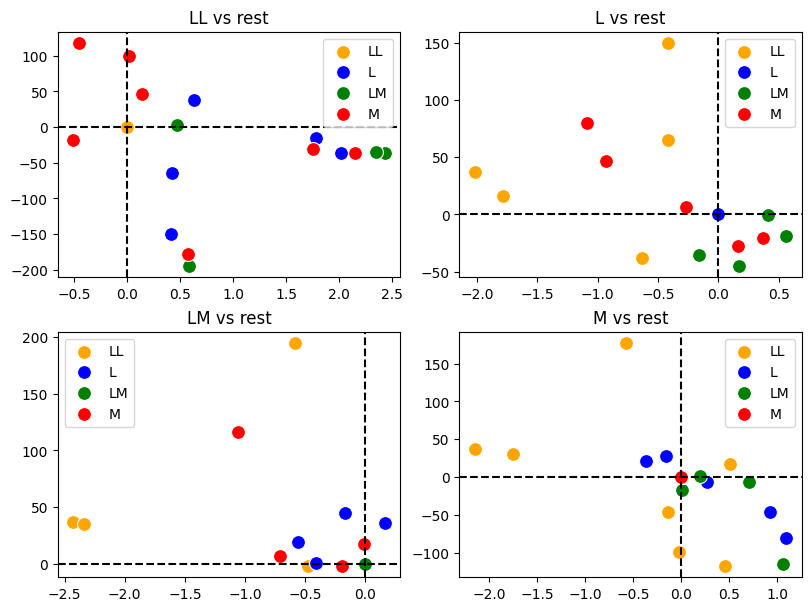

In [47]:
big_degrees = ["L", "LM", "M", "LL"]
small_degrees = ["L", "LM1", "LM2", "M", "LL"]
fig, axes = plt.subplots(2, 2, figsize=(8, 6), squeeze = False, constrained_layout=True)

left_counter = 0
for left in range(len(left_degrees)):
    if left_degrees[left] not in big_degrees: continue
    ax = axes[left_counter // 2, left_counter % 2]
    left_counter += 1
    ax.axvline(0, linestyle="dashed", color = "black")
    ax.axhline(0, linestyle="dashed", color = "black")
    ax.set_title(f"{left_degrees[left]} vs rest")

    for right in range(len(left_degrees)):
        x = paired_diff_eff[:, left, right]
        y = -paired_diff_sel[:, left, right]
        sns.scatterplot(ax= ax,x=x, y=y, color = color_dict[left_degrees[right]], label=left_degrees[right], s=100)

    ax.legend();


In [60]:
curr_a = a[:,0,:,:,1,...]
curr_a = curr_a / ma.median(curr_a, axis = (1,2,3,-1), keepdims=True)

paired_diff_eff_small = curr_a[:, :,:,None,...] - curr_a[:,:,None,...]

paired_diff_eff_small = ma.mean(paired_diff_eff_small, axis=(1, -1,-2))


selectivity_small = selectivity_small / ma.median(selectivity_small, axis = (-1), keepdims=True)
paired_diff_sel_small = selectivity_small[:,:,None] - selectivity_small[:,None,:]

(8, 3, 6, 4000, 6)

In [43]:
comp_M_eff = paired_diff_eff_small[:,5,:]
comp_M_sel = paired_diff_sel_small[:,5,:]

avg_eff = ma.mean(comp_M_eff, axis = (0))
avg_sel = ma.mean(comp_M_sel, axis = (0))

sem_eff = []
sem_sel = []
for i in range(6):
    sem_eff.append(ma.std(comp_M_eff[:,i]) / ma.sqrt(ma.count(comp_M_eff[:,i])))
    sem_sel.append(ma.std(comp_M_sel[:,i]) / ma.sqrt(ma.count(comp_M_eff[:,i])))

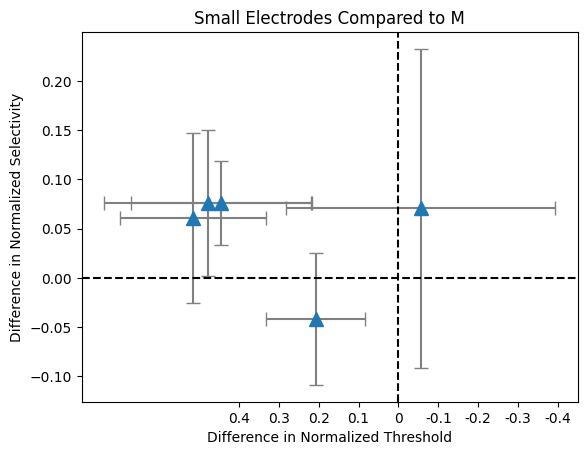

In [114]:
plot_ind = [0, 1, 2, 3, 4]
plt.errorbar(x=avg_eff[plot_ind], y=-avg_sel[plot_ind], yerr=sem_sel[:5], xerr=sem_eff[:5], fmt='^', capsize=5,ms = 10, ecolor='gray', label='Avg with SEM')
plt.xlabel("Difference in Normalized Threshold")
plt.ylabel("Difference in Normalized Selectivity")
plt.title(f"Small Electrodes Compared to M")
plt.axvline(0, linestyle="dashed", color = "black")
plt.axhline(0, linestyle="dashed", color = "black")
xticks=[0.4,0.3, 0.2,0.1, 0,-0.1, -0.2,-0.3, -0.4]
plt.xticks(xticks, reversed(xticks));

In [50]:
avg_sel

masked_array(data=[-0.1426412434692172, 0.03706917701088923, --,
                   0.07236551736149327, 0.031220320508394836, 0.0],
             mask=[False, False,  True, False, False, False],
       fill_value=1e+20)

In [51]:
avg_eff

masked_array(data=[-0.1729989601546955, 0.19778419794451801, --,
                   0.28950245517321405, 0.282052083790655, 0.0],
             mask=[False, False,  True, False, False, False],
       fill_value=1e+20)

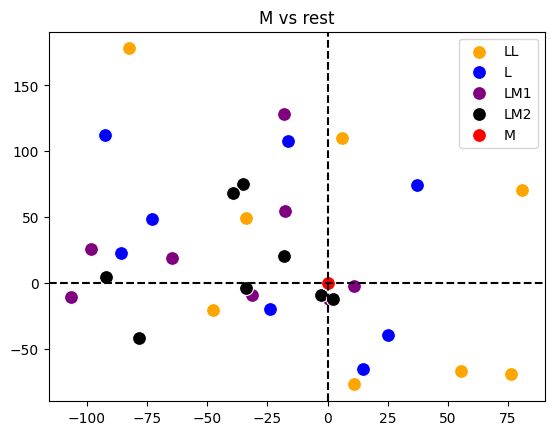

In [95]:
plt.axvline(0, linestyle="dashed", color = "black")
plt.axhline(0, linestyle="dashed", color = "black")
plt.title(f"M vs rest")

for right in range(len(left_degrees)):
    x = -paired_diff_eff_small[:,5, right]
    y = paired_diff_sel_small[:,5, right]
    sns.scatterplot(x=x, y=y, color = color_dict[left_degrees[right]], label=left_degrees[right], s=100)

plt.legend();

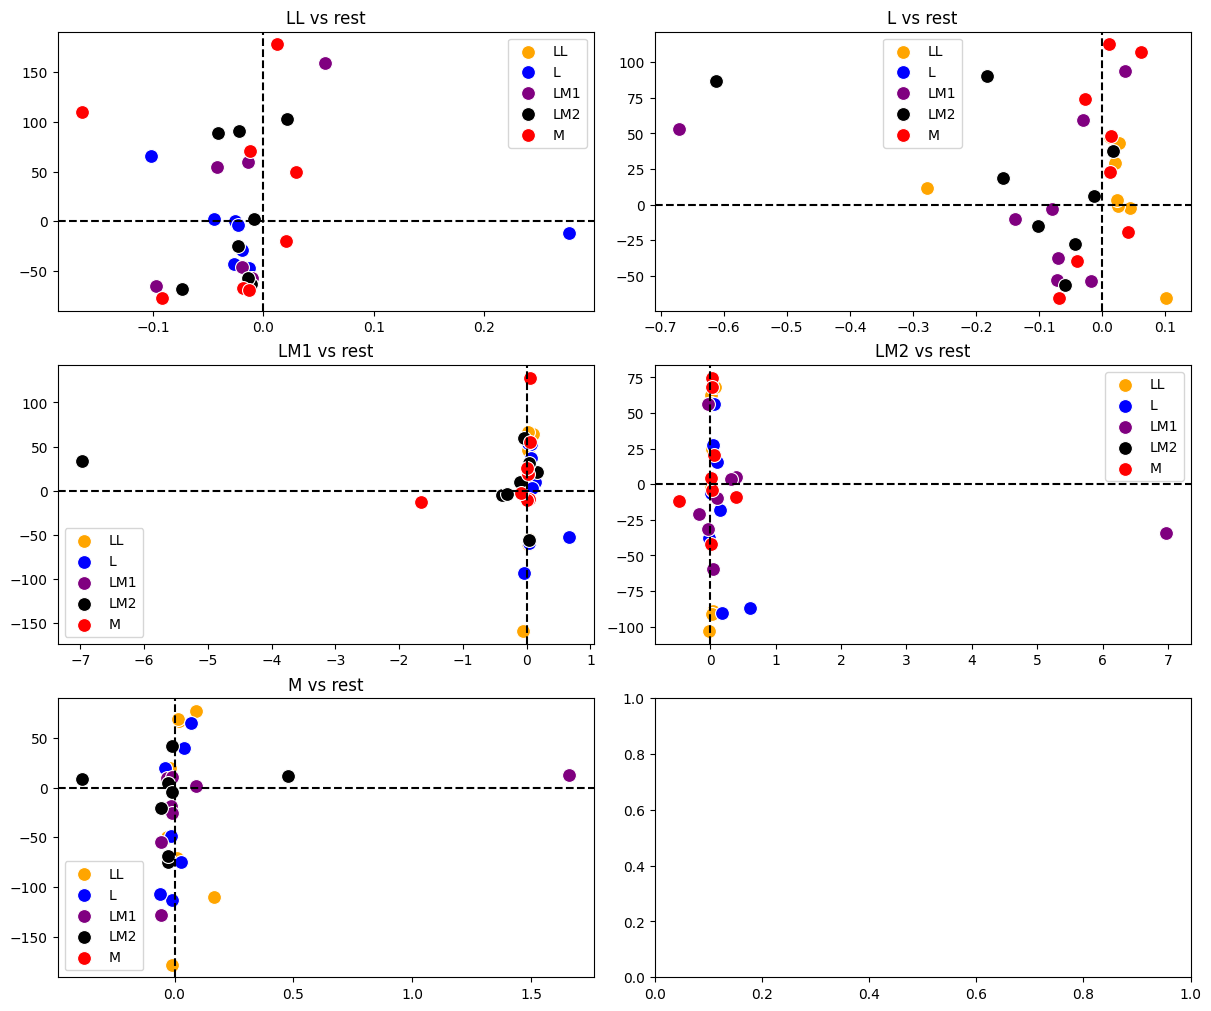

In [192]:
color_dict = {"L": "blue", "LM": "green", "M": "red", "LL": "orange", "LM1": "purple", "LM2": "black" }

small_degrees = ["L", "LM1", "LM2", "M", "LL"]
fig, axes = plt.subplots(3, 2, figsize=(12, 10), squeeze = False, constrained_layout=True)

left_counter = 0
for left in range(len(left_degrees)):
    if left_degrees[left] not in small_degrees: continue
    ax = axes[left_counter // 2, left_counter % 2]
    left_counter += 1
    ax.axvline(0, linestyle="dashed", color = "black")
    ax.axhline(0, linestyle="dashed", color = "black")
    ax.set_title(f"{left_degrees[left]} vs rest")

    for right in range(len(left_degrees)):
        x = -(1/paired_diff_eff_small[:, left, right])
        y = -paired_diff_sel_small[:, left, right]
        sns.scatterplot(ax= ax,x=x, y=y, color = color_dict[left_degrees[right]], label=left_degrees[right], s = 100)

    ax.legend();


In [30]:
test

[99.21575234112784,
 62.302616921800706,
 62.14111074647369,
 68.92514605234425,
 162.94696269961244,
 200.77134674986092,
 165.1422824604244,
 280.9334690824657,
 206.4105373811817,
 141.80427028592206,
 188.77722581432994,
 253.5790404132771,
 300.17885783268457,
 222.94378690561396,
 322.0597214780019,
 273.275468523092,
 424.0624336582351,
 274.23465540848133,
 229.12676628196522,
 246.48804946421586,
 104.80056857697251,
 88.78432281544904,
 69.7846809650558,
 67.96303921798541]

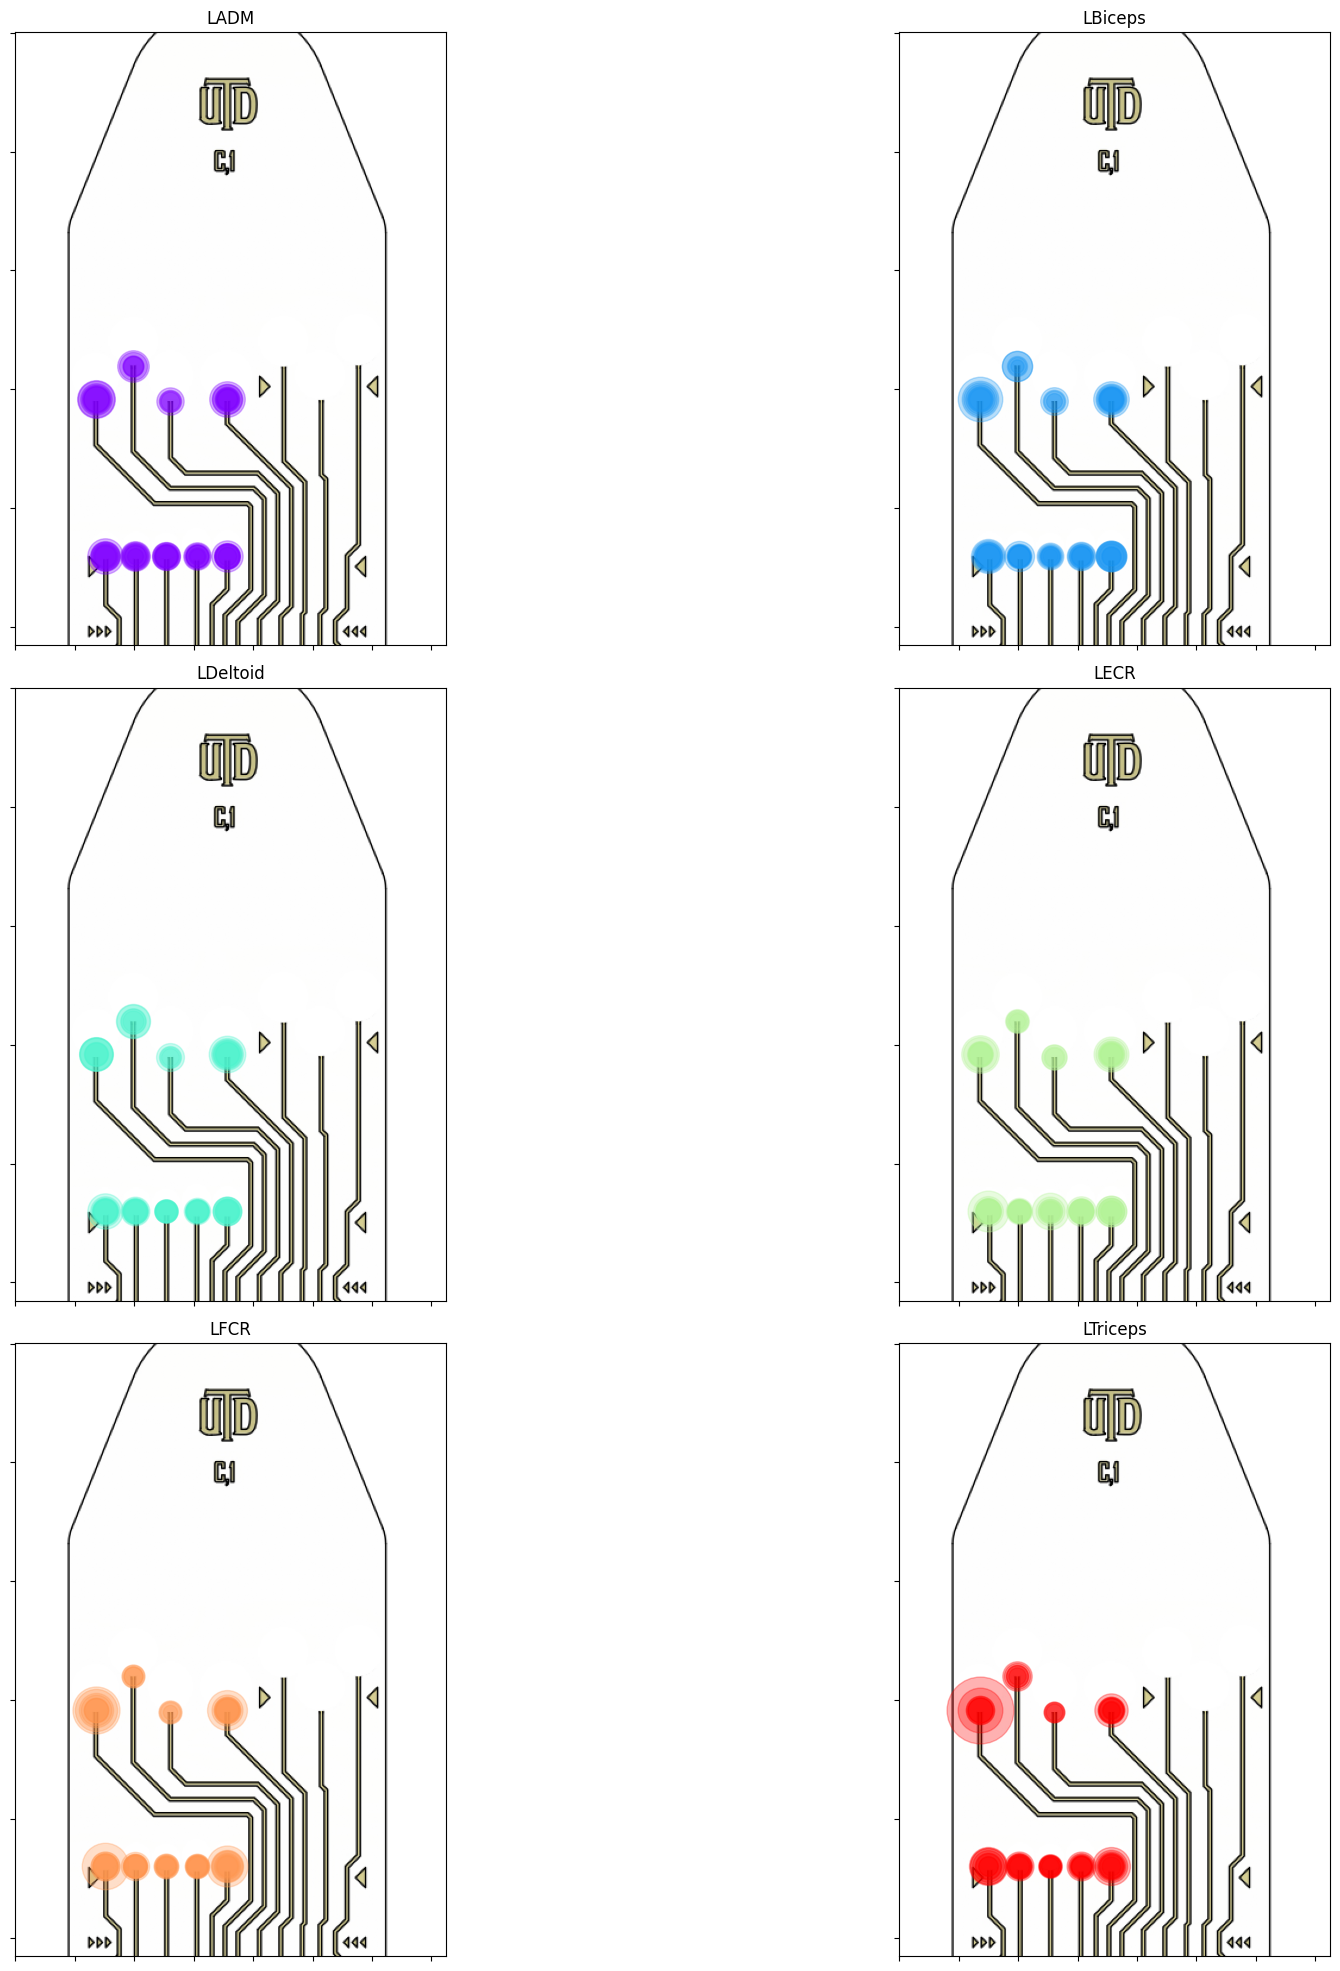

In [31]:
contact_ind = 0 # mono or bi


### NEEDS TO BE CHANGED WHEN CHANGING SIZE/CONTACT
### ['LL', 'L', 'LM', 'LM1', 'LM2', 'M']

### ACTUAL CALCULATION

x_vals_big = {"LL":(67.7, 308), "L":(98.7, 280), "LM":(130, 310), "M": (178, 308)}
x_vals_small = {"LL":(75, 440), "L":(101, 440), "LM1":(127, 440), "LM2": (153, 440), "M": (178, 440)}

fig, ax = plt.subplots(3, 2, figsize=(20,20))    
ax = ax.flatten()

im = plt.imread("/home/andres/C_SMA_LAR_white2.png")

for musc,m in enumerate(model.response):

    a_big = a[:,contact_ind,:,:,0,:,musc]
    a_big = a_big / ma.median(a[:,contact_ind,:,:,0,:,musc], axis = (1,2,3), keepdims=True)

    a_small = a[:,contact_ind,:,:,1,:,musc]
    a_small = a_small / ma.median(a[:,contact_ind,:,:,1,:,musc], axis = (1,2,3), keepdims=True)

    a_mean_big = ma.mean(a_big, axis=(1,-1))
    a_mean_small = ma.mean(a_small, axis=(1,-1))
    
    
    pvalues = []
    mask = []
    data = []
    mean_list_big = []
    mean_list_small = []

    for sub_ind, s in enumerate(subjects):
        for l_ind, l in enumerate(left_degrees):
            if a_mean_big.mask[sub_ind,l_ind].all():
                    continue
                
            mean_list_big.append(
                (
                    subjects[sub_ind],
                    left_degrees[l_ind],
                    a_mean_big[sub_ind,l_ind]
                )
            )
            
    for sub_ind, s in enumerate(subjects):
        for l_ind, l in enumerate(left_degrees):
            if a_mean_small.mask[sub_ind,l_ind].all():
                    continue
                
            mean_list_small.append(
                (
                    subjects[sub_ind],
                    left_degrees[l_ind],
                    a_mean_small[sub_ind,l_ind]
                )
            )



    # plt.figure(figsize=(20, 20))
        
    for i, z in enumerate(mean_list_big):
        if z[1] not in x_vals_big:
            continue
        eff_size = mean_list_big[i][2]*300
        ax[musc].scatter(x_vals_big[z[1]][0], x_vals_big[z[1]][1], s = eff_size,alpha=0.3, color = model._get_colors(model.n_response)[musc])
        
    for i, z in enumerate(mean_list_small):
        if z[1] not in x_vals_small:
            continue
        eff_size = mean_list_small[i][2]*300
        ax[musc].scatter(x_vals_small[z[1]][0], x_vals_small[z[1]][1], s = eff_size,alpha=0.3, color = model._get_colors(model.n_response)[musc])
    plt.tight_layout()
    implot = ax[musc].imshow(im)
    ax[musc].set_xticklabels([])
    ax[musc].set_yticklabels([])
    ax[musc].set_title(f"{model.response[musc]}")
    


In [32]:
enumerate(model.response)

In [30]:
a_big = a[:,contact_ind,:,:,0,...]
a_big = a_big / ma.median(a[:,contact_ind,:,:,0,...], axis = (1,2,3,-1), keepdims=True)
a_big.shape

(8, 3, 6, 4000, 6)

In [31]:
import matplotlib.pyplot as plt


In [ ]:
im = plt.imread("/home/andres/repos/rat-mapping-paper/figures/efficiency_bipolar.png")
plt.imshow(im)

# Right Biceps

In [36]:
USER = os.environ["USER"]
 
src = f"/home/andres/repos/rat-mapping-paper/reports/non-hierarchical/C_SMA_LAR/non_hierarchical_bayesian_model/rbiceps.pkl"
# src = f"/home/{USER}/repos/rat-mapping-paper/reports/C_SMA_LAR/rbiceps.pkl"
with open(src, "rb") as f:
    (
    df_rbiceps, encoder_dict_rbiceps, model_rbiceps, posterior_sample_rbiceps
    ) = pickle.load(f)

In [37]:
a_rbiceps = posterior_sample_rbiceps[site.a]
a_rbiceps.shape

(4000, 8, 70, 3, 1)

In [38]:
compound_position = encoder_dict_rbiceps[model_rbiceps.features[1]].inverse_transform(sorted(df_rbiceps['compound_position'].unique()))

In [39]:
compound_position

array(['-C5L', '-C5LL', '-C5LM', '-C5LM1', '-C5LM2', '-C5M', '-C6L',
       '-C6LL', '-C6LM', '-C6LM1', '-C6LM2', '-C6M', '-C6R', '-C6RM',
       '-C6RR', '-C7LM', '-C7M', '-C7R', '-C7RM', '-C7RR', 'C5L-C5LL',
       'C5LM1-C5L', 'C5LM1-C5LL', 'C5LM2-C5L', 'C5LM2-C5LL',
       'C5LM2-C5LM1', 'C5LM2-C5M', 'C5LM2-C6L', 'C5LM2-C6LL', 'C5M-C5L',
       'C5M-C5LL', 'C5M-C5LM', 'C5M-C5LM1', 'C5M-C5LM2', 'C5M-C6L',
       'C5M-C6LL', 'C6L-C6LL', 'C6LL-C6L', 'C6LM-C6L', 'C6LM-C6LL',
       'C6LM-C6M', 'C6LM-C6R', 'C6LM-C6RM', 'C6LM-C6RR', 'C6LM1-C6L',
       'C6LM1-C6LL', 'C6LM2-C6L', 'C6LM2-C6LL', 'C6LM2-C6LM1', 'C6M-C6L',
       'C6M-C6LL', 'C6M-C6LM', 'C6M-C6LM1', 'C6M-C6LM2', 'C6M-C6R',
       'C6M-C6RM', 'C6M-C6RR', 'C6R-C6RR', 'C6RM-C6R', 'C6RM-C6RR',
       'C7LM-C7M', 'C7LM-C7R', 'C7LM-C7RM', 'C7LM-C7RR', 'C7M-C7R',
       'C7M-C7RM', 'C7M-C7RR', 'C7R-C7RR', 'C7RM-C7R', 'C7RM-C7RR'],
      dtype=object)

In [40]:
mono = [c for c in compound_position if c.split("-")[0] == "" or c.split("-")[1] == ""]
mono

['-C5L',
 '-C5LL',
 '-C5LM',
 '-C5LM1',
 '-C5LM2',
 '-C5M',
 '-C6L',
 '-C6LL',
 '-C6LM',
 '-C6LM1',
 '-C6LM2',
 '-C6M',
 '-C6R',
 '-C6RM',
 '-C6RR',
 '-C7LM',
 '-C7M',
 '-C7R',
 '-C7RM',
 '-C7RR']

In [41]:
laterality_r = ['M','RM','R','RR']

In [42]:
mono = [m for m in mono if m.split("-")[1][2] in laterality_r]
mono

['-C5M', '-C6M', '-C6R', '-C6RM', '-C6RR', '-C7M', '-C7R', '-C7RM', '-C7RR']

In [43]:
contact_ind = encoder_dict_rbiceps[model_rbiceps.features[1]].transform(mono)
contact_ind

array([ 5, 11, 12, 13, 14, 16, 17, 18, 19])

In [44]:
a_rbiceps.shape

(4000, 8, 70, 3, 1)

In [45]:
a_test = a_rbiceps[..., contact_ind, :, :]
a_test.shape

(4000, 8, 9, 3, 1)

In [46]:
mono

['-C5M', '-C6M', '-C6R', '-C6RM', '-C6RR', '-C7M', '-C7R', '-C7RM', '-C7RR']

In [47]:
laterality_r

['M', 'RM', 'R', 'RR']

In [48]:
mono.index("-C6M")

1

In [49]:
'-C5RM' in mono

False

In [50]:
a_test.shape

(4000, 8, 9, 3, 1)

In [51]:
np.isnan(a_test).sum() / 4000

155.0

In [52]:
a_test.shape

(4000, 8, 9, 3, 1)

In [53]:
np.isnan(a_test).shape

(4000, 8, 9, 3, 1)

In [54]:
segments = ["-C5", "-C6", "-C7"]

arr_biceps = []
mask_biceps = [] 

# for subject in subjects:
#     for size in sizes:  
for segment in segments:
    for lat in laterality_r:
        cpos = f"{segment}{lat}"
        if cpos in mono:
            arr_biceps.append(a_rbiceps[:,:,mono.index(cpos),...])

        else:
            arr_biceps.append(np.full(a_rbiceps[:, :, 0, ...].shape, np.nan))

arr_biceps = np.array(arr_biceps)
arr_biceps = arr_biceps.reshape(len(segments), len(laterality_r), *arr_biceps.shape[1:])
arr_biceps.shape


(3, 4, 4000, 8, 3, 1)

In [55]:
arr_biceps = ma.masked_invalid(arr_biceps)

In [56]:
t = np.nanmean(arr_biceps[..., 0, :], axis=(0, 2, -1))


In [57]:
q = (t[:, None, :] - t[None, :, :])


In [58]:
stats.ttest_1samp(ma.masked_invalid(q), popmean=0, axis=-1).pvalue


array([[       nan, 0.01793523, 0.32223069, 0.26020173],
       [0.01793523,        nan, 0.13878684, 0.01941746],
       [0.32223069, 0.13878684,        nan, 0.0405398 ],
       [0.26020173, 0.01941746, 0.0405398 ,        nan]])

In [59]:
size_ind = 0 # big or small

### ACTUAL CALCULATION
a_test = arr_biceps[...,size_ind,:]
a_test = a_test / ma.median(a_test, axis = (0,1, 2,-1), keepdims=True)

a_mean = ma.mean(a_test, axis=(0, 2,-1))
a_mean.shape

t = (a_mean[None, :, :] - a_mean[:, None, :])
t.shape


(4, 4, 8)

In [60]:
test = stats.ttest_1samp(t, popmean=0, alternative="two-sided", axis=(-1))

In [61]:
p.shape

(6,)

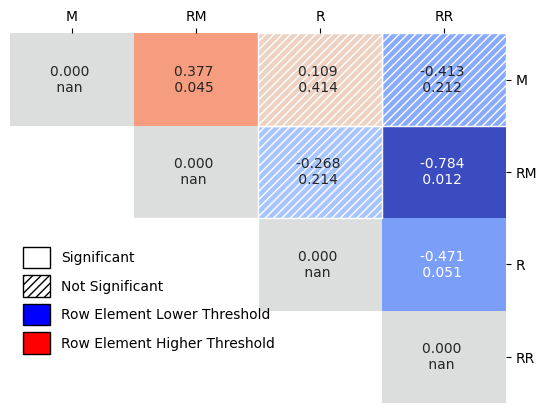

In [62]:
ind = laterality_r

### GET MEAN TO PLOT
p_mean = t.mean(axis=-1)
### GET P VALUES
p = test.pvalue
### MASK NANs
p_mean = p_mean.data
# p_mean = p_mean.reshape(len(ind),len(ind))

# ### GET VALUES WE WANT TO PLOT
p_ = p

#FOR ANNOTATION
data = []
for ind_i, i in enumerate(p_):
    for ind_j, j in enumerate(i):
        data.append(f"{p_mean[ind_i, ind_j]:.3f} \n {j:.3f}  ")
        
data = np.array(data).reshape(len(ind),len(ind))

#MASK LOWER TRIANGLE
mask2= np.array(p_)
mask2 = np.tril(np.ones_like(mask2), k=-1).astype(bool)

#CORRECT LABELS
labels = np.array(laterality_r)
labels = labels.astype('U20')

#PLOT
ax=sns.heatmap(p_mean   , xticklabels=labels, yticklabels=labels,annot=data,fmt = '',center = 0, cmap = "coolwarm",cbar = False, mask = mask2)


##ADD HATCH FOR SIGNIFICANCE
handles = []
hatch_mask = p_ > 0.1

for i in range (p_.shape[0]):
    for j in range(p_.shape[1]):
        if hatch_mask[i, j]:
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, hatch='////', edgecolor='white'))
handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                    hatch='', label="Significant"))
handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                    hatch='////', label="Not Significant"))
handles.append(plt.Rectangle((0, 0), 0, 0, color='blue', ec='black',
                    hatch='', label="Row Element Lower Threshold"))
handles.append(plt.Rectangle((0, 0), 0, 0, color='Red', ec='black',
                    hatch='', label="Row Element Higher Threshold"))
ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(0, .1),
        handlelength=2, handleheight=2, frameon=False)
ax.tick_params(left= False,labelleft = False, bottom= False,labelbottom= False,right=True, top=True, labelright=True, labeltop=True, labelrotation=0)

ax.yaxis.tick_right()

In [63]:
p_mean.data

In [64]:
a.shape

(8, 2, 3, 6, 2, 4000, 6)

# Big Vs Small

In [53]:
ind_big = [0,1,2,2,5]
ind_small = [0,1,3,4,5]

In [54]:
curr_a = a[:,0,...]

In [57]:
temp_a = a[:, 0, :, :, 0, ...]

In [58]:
temp_a.shape

(8, 3, 6, 4000, 6)

In [55]:
a.shape

(8, 2, 3, 6, 2, 4000, 6)

In [56]:
curr_a.shape

(8, 3, 6, 2, 4000, 6)

In [65]:
curr_a = a[:,0,...]
curr_a = curr_a / ma.median(curr_a, axis = (1,2,3,-2,-1), keepdims=True)


big = curr_a[:, :, :, 0, ...][..., ind_big, :, :]
small = curr_a[:, :, :, 1, ...][..., ind_small, :, :] 

# # big_eff = ma.mean(big, axis=(1, -1, -2))
# # small_eff = ma.mean(small, axis=(1, -1, -2))

diff = big - small

diff = ma.mean(diff, axis=(1, -1, -2))
#(8, 5)

In [66]:
diff.shape

(8, 5)

In [57]:
selectivity_small = selectivity_small / ma.median(selectivity_small, axis = (-1), keepdims=True)
paired_diff_sel_small = selectivity_small[:,:,None] - selectivity_small[:,None,:]

comp_M_eff = paired_diff_eff_small[:,5,:]
comp_M_sel = paired_diff_sel_small[:,5,:]

avg_eff = ma.mean(comp_M_eff, axis = (0))
avg_sel = ma.mean(comp_M_sel, axis = (0))

sem_eff = []
sem_sel = []
for i in range(6):
    sem_eff.append(ma.std(comp_M_eff[:,i]) / ma.sqrt(ma.count(comp_M_eff[:,i])))
    sem_sel.append(ma.std(comp_M_sel[:,i]) / ma.sqrt(ma.count(comp_M_eff[:,i])))
    
plot_ind = [0, 1, 2, 3, 4]
plt.errorbar(x=avg_eff[plot_ind], y=-avg_sel[plot_ind], yerr=sem_sel[:5], xerr=sem_eff[:5], fmt='^', capsize=5,ms = 10, ecolor='gray', label='Avg with SEM')
plt.xlabel("Difference in Normalized Threshold")
plt.ylabel("Difference in Normalized Selectivity")
plt.title(f"Small Electrodes Compared to M")
plt.axvline(0, linestyle="dashed", color = "black")
plt.axhline(0, linestyle="dashed", color = "black")
xticks=[0.4,0.3, 0.2,0.1, 0,-0.1, -0.2,-0.3, -0.4]
plt.xticks(xticks, reversed(xticks));

(8, 5)

In [67]:
combo_sel = np.concatenate([selectivity_big, selectivity_small], axis=1)

In [70]:
selectivity_big = selectivity_big / ma.median(combo_sel, axis = (-1), keepdims=True)
selectivity_small = selectivity_small / ma.median(combo_sel, axis = (-1), keepdims=True)

In [71]:
selectivitiy_diff = selectivity_big[:,ind_big] - selectivity_small[:,ind_small]

In [73]:
selectivitiy_diff.shape

(8, 5)

In [77]:
diff

masked_array(
  data=[[1.9705813791859281, -0.09159022001169002, -0.20787514401909682,
         -0.16625617298558612, -0.012967281914178612],
        [0.15424533710663024, -0.4097005165002978, -0.16078356331622654,
         -0.34896387621116687, -0.018619162642063054],
        [-0.3936929429227142, -0.4276933910145784, --, --,
         -0.3698503152285001],
        [0.2964184007580182, --, --, --, 0.16067355939653918],
        [-0.13907896807573422, --, --, --, -0.13099240557055836],
        [--, --, --, --, -0.00445271738617877],
        [-0.3646587745828076, -0.35310221034132816, -0.16173051972459454,
         -0.05758477786355027, -0.2471344111353871],
        [-1.1356861112900847, -1.292513309593323, -1.378170306278203,
         -1.2028762735370688, -1.0393211300193004]],
  mask=[[False, False, False, False, False],
        [False, False, False, False, False],
        [False, False,  True,  True, False],
        [False,  True,  True,  True, False],
        [False,  True,  True,  Tr

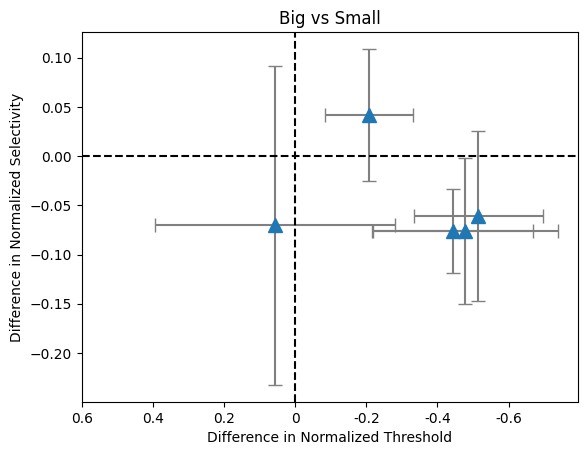

In [105]:
avg_eff = ma.mean(diff, axis = (0))
avg_sel = ma.mean(selectivitiy_diff, axis = (0))

sem_eff = []
sem_sel = []
for i in range(5):
    sem_eff.append(ma.std(diff[:,i]) / ma.sqrt(ma.count(diff[:,i])))
    sem_sel.append(ma.std(selectivitiy_diff[:,i]) / ma.sqrt(ma.count(selectivitiy_diff[:,i])))
    
plot_ind = [0, 1, 2, 3, 4]
plt.errorbar(x=-avg_eff[plot_ind], y=avg_sel[plot_ind], yerr=sem_sel[:5], xerr=sem_eff[:5], fmt='^', capsize=5,ms = 10, ecolor='gray', label='Avg with SEM')
plt.xlabel("Difference in Normalized Threshold")
plt.ylabel("Difference in Normalized Selectivity")
plt.title(f"Big vs Small")
xticks=[0.6, 0.4, 0.2, 0, -0.2,-0.4, -0.6]
plt.xticks(xticks, reversed(xticks));
plt.axvline(0, linestyle="dashed", color = "black")
plt.axhline(0, linestyle="dashed", color = "black")


In [107]:
avg_eff

masked_array(data=[0.05544690288274797, -0.5149199294922434,
                   -0.4771398833345302, -0.44392027514934307,
                   -0.20783298306245337],
             mask=[False, False, False, False, False],
       fill_value=1e+20)

In [108]:
avg_sel

masked_array(data=[-0.07046027211747798, -0.06049643602381114,
                   -0.07573131131050595, -0.07631368755012752,
                   0.041570983644085846],
             mask=[False, False, False, False, False],
       fill_value=1e+20)

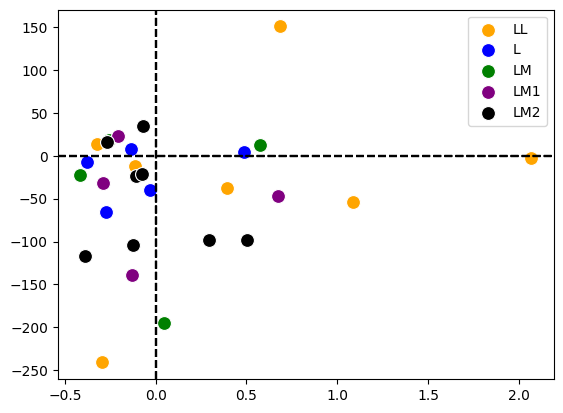

In [58]:
color_dict = {"L": "blue", "LM": "green", "M": "red", "LL": "orange", "LM1": "purple", "LM2": "black" }

for left in range(5):
    plt.axvline(0, linestyle="dashed", color = "black")
    plt.axhline(0, linestyle="dashed", color = "black")
    x = diff[:, left]
    y = selectivitiy_diff[:, left]
    sns.scatterplot(x=x, y=y, color = color_dict[left_degrees[left]],label=left_degrees[left], s = 100)

plt.legend();

In [ ]:
contact_ind = 0 # mono or bi

### ACTUAL CALCULATION
a_together = a[:,contact_ind,...]

# a_together = a_together / ma.median(a_together, axis = (1,2,3,-1), keepdims=True)


a_test_big = a_together[:,:,:,0,:,4]
a_test_small = a_together[:,:,:,1,:,4]

a_test_big = a_test_big[:, :, ind_big, ...]
a_test_small = a_test_small[:, :, ind_small, ...]

a_mean_big = ma.mean(a_test_big, axis=(1, -1))
a_mean_small = ma.mean(a_test_small, axis=(1, -1))

t = a_mean_big[:, :, None] - a_mean_small[:, None, :]
ttest = stats.wilcoxon(t, axis=0, nan_policy='omit')
pvalue = ttest.pvalue

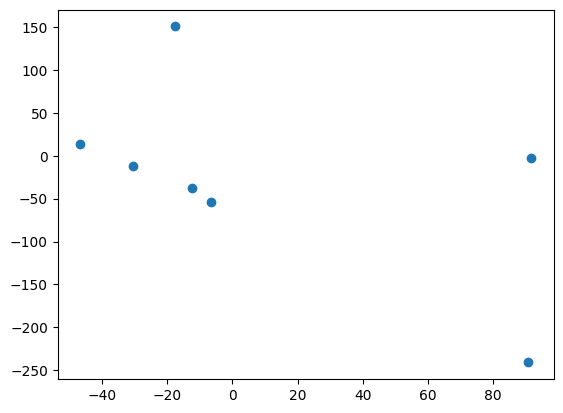

In [261]:
plt.scatter(t[:, 0, 0], selectivitiy_diff[:, 0, 0])

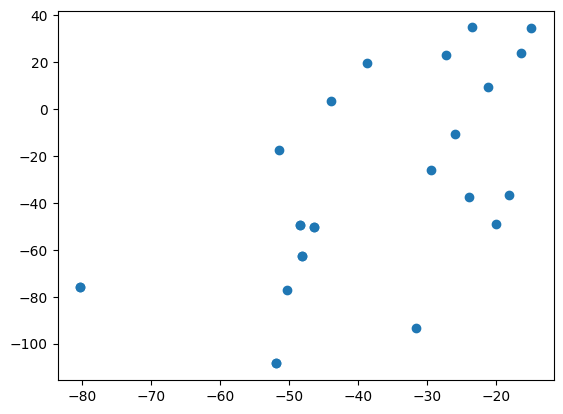

In [220]:
plt.scatter(selectivitiy_diff.mean(axis=0), t.mean(axis=0))

(-50.0, 50.0)

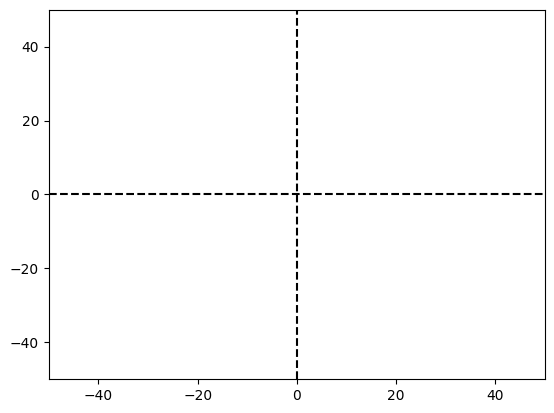

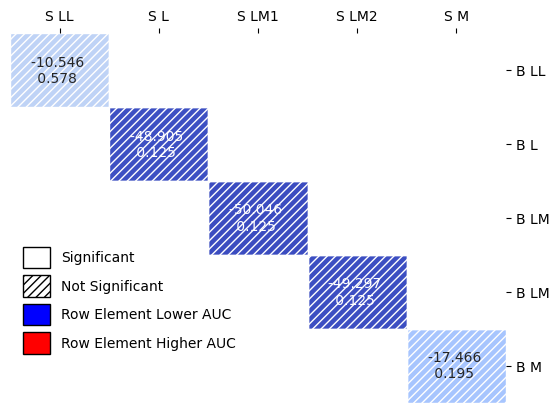

In [70]:
### GET P VALUES
p = ttest.pvalue

### GET MEAN TO PLOT
p_mean = t.mean(axis=0)

### GET VALUES WE WANT TO PLOT
p_ = p

#FOR ANNOTATION
data = []
for ind_i, i in enumerate(p_):
    for ind_j, j in enumerate(i):
        data.append(f"{p_mean[ind_i, ind_j]:.3f} \n {j:.3f}  ")
        # 
data = np.array(data).reshape(5,5)

#MASK LOWER TRIANGLE
mask2= np.array(p_)
mask2 = np.tril(np.ones_like(mask2), k=-1).astype(bool) + np.triu(np.ones_like(mask2), k=+1).astype(bool)

#CORRECT LABELS
y_labs = ['B LL', 'B L', 'B LM', 'B LM', 'B M']
x_labs = ['S LL', 'S L', 'S LM1', 'S LM2', 'S M']

# if contact_ind == 0:
#     labels[ind] = labels[ind]
# else:
#     labels[ind] = np.char.add(labels[ind],"-M")

#PLOT
ax=sns.heatmap(p_mean, xticklabels=x_labs, yticklabels=y_labs,annot=data,fmt = '',center = 0, cmap = "coolwarm",cbar = False, mask = mask2)


##ADD HATCH FOR SIGNIFICANCE
handles = []
hatch_mask = p_ > 0.1

for i in range (p_.shape[0]):
    for j in range(p_.shape[1]):
        if hatch_mask[i, j]:
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, hatch='////', edgecolor='white'))
handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                    hatch='', label="Significant"))
handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                    hatch='////', label="Not Significant"))
handles.append(plt.Rectangle((0, 0), 0, 0, color='blue', ec='black',
                    hatch='', label="Row Element Lower AUC"))
handles.append(plt.Rectangle((0, 0), 0, 0, color='Red', ec='black',
                    hatch='', label="Row Element Higher AUC"))
ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(0, .1),
        handlelength=2, handleheight=2, frameon=False)
ax.tick_params(left= False,labelleft = False, bottom= False,labelbottom= False,right=True, top=True, labelright=True, labeltop=True, labelrotation=0)

ax.yaxis.tick_right()
